In [1]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from flowjax.flows import (
    MaskedAutoregressiveFlow,
    CouplingFlow,
    BlockNeuralAutoregressiveFlow,
    )
from flowjax.bijections import (
    Invert,
    Chain,
    Exp,
    BlockAutoregressiveNetwork,
    Affine,
    RationalQuadraticSpline,
    )
from flowjax.distributions import Normal, Transformed
from flowjax.train import fit_to_data

In [2]:
np.random.seed(0)

In [3]:
data = np.load('./posteriors.pkl', allow_pickle=True)
true = np.array([p.attrs['injection_parameters']['chirp_mass'] for p in data])
posteriors = [np.array(p['chirp_mass']) for p in data]
n = min(p.size for p in posteriors)

x = np.array([np.random.choice(p, n, replace=False) for p in posteriors])
c = np.repeat(true[:, None], x.shape[1], axis=1)

In [4]:
x.shape, c.shape

((100, 462), (100, 462))

In [5]:
x, c = map(
    lambda z: jnp.array(np.concatenate(z)[:, None]),
    (x, c),
    )

I0000 00:00:1696458482.436074   86374 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
x.shape, c.shape

((46200, 1), (46200, 1))

In [22]:
key = jax.random.PRNGKey(0)

In [31]:
key, key_ = jax.random.split(key)

base = Normal(loc=jnp.zeros(1), scale=jnp.ones(1))

# flow = BlockNeuralAutoregressiveFlow(
#     key=key_,
#     base_dist=base,
#     cond_dim=1,
#     nn_depth=1,
#     nn_block_dim=10,
#     flow_layers=1,
#     invert=True,
#     )

bijections = [
    BlockAutoregressiveNetwork(
        key=key_,
        dim=1,
        cond_dim=1,
        depth=1,
        block_dim=10,
        ),
    Exp(shape=(1,)),
    ]
bijection = Invert(Chain(bijections))
flow = Transformed(base, bijection)

In [42]:
sum(jnp.asarray(p).flatten().size for p in jax.tree_util.tree_flatten(flow)[0])

TypeError: Value '<function _block_tanh_activation.<locals>.activation at 0x7f26f6d69120>' with dtype object is not a valid JAX array type. Only arrays of numeric types are supported by JAX.

In [28]:
key, key_ = jax.random.split(key)
flow, losses = fit_to_data(
    key=key_,
    dist=flow,
    x=x,
    condition=c,
    loss_fn=None,
    max_epochs=1_000,
    max_patience=10,
    batch_size=1_000,
    val_prop=0.1,
    learning_rate=1e-3,
    optimizer=None,
    # filter_spec: Callable | PyTree = eqx.is_inexact_array,
    show_progress=True,
    )

 13%|▍  | 129/1000 [00:30<03:29,  4.17it/s, train=-1.9178649, val=-1.8786111 (Max patience reached)]


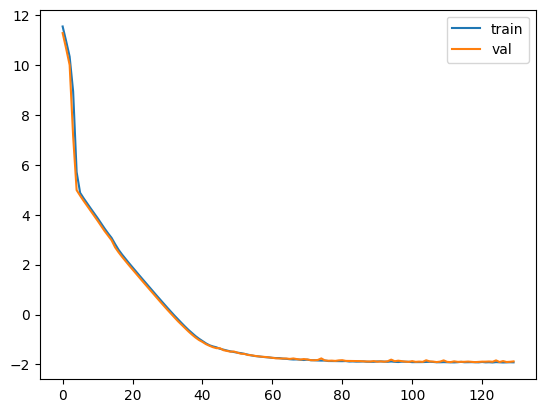

In [29]:
for label, loss in losses.items():
    plt.plot(loss, label=label)
plt.legend();

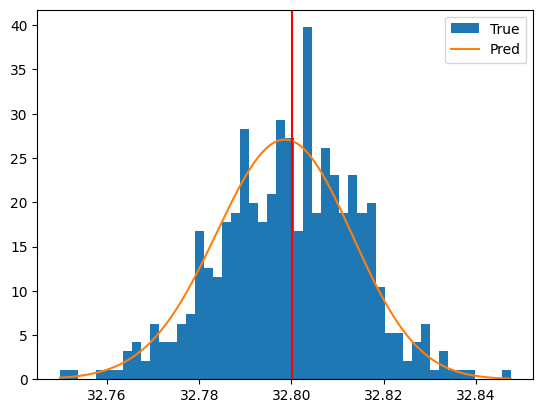

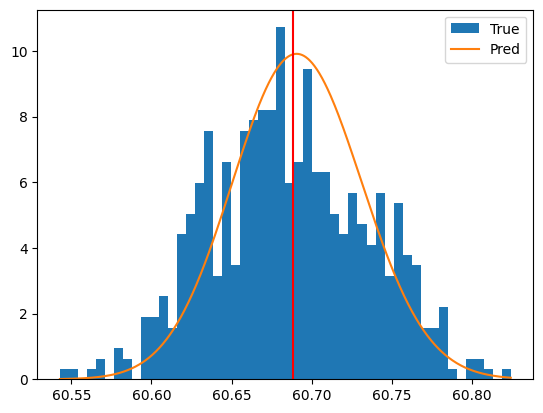

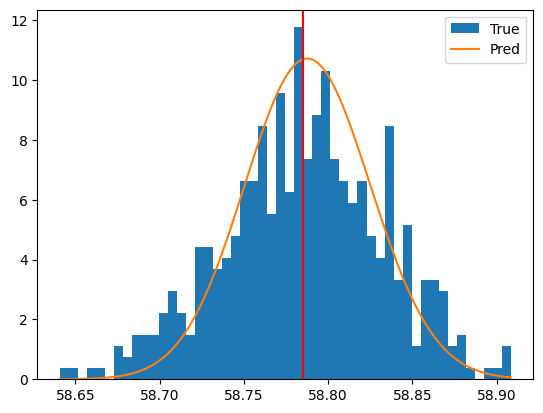

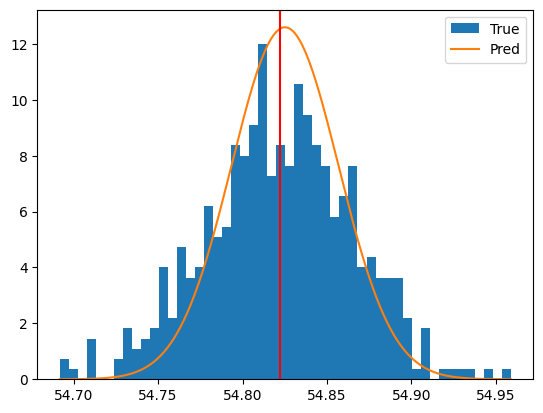

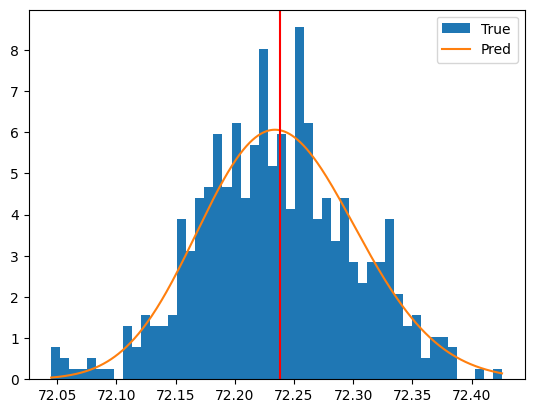

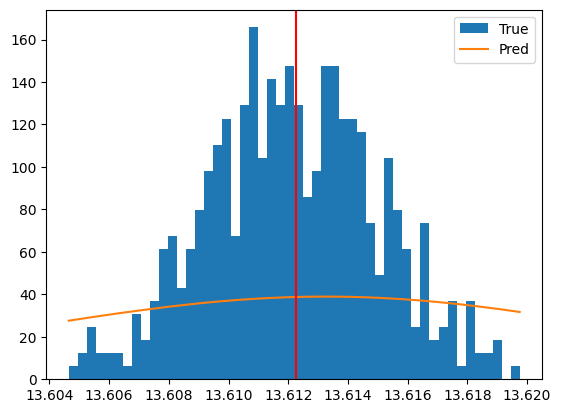

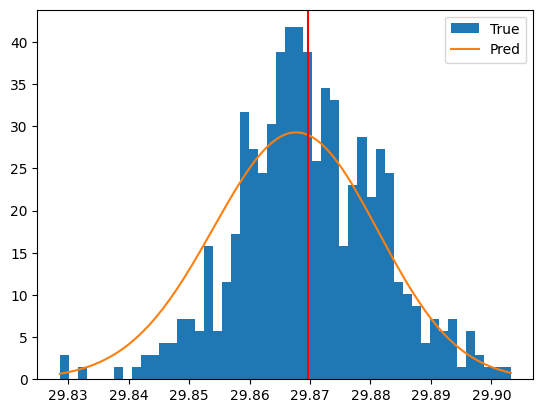

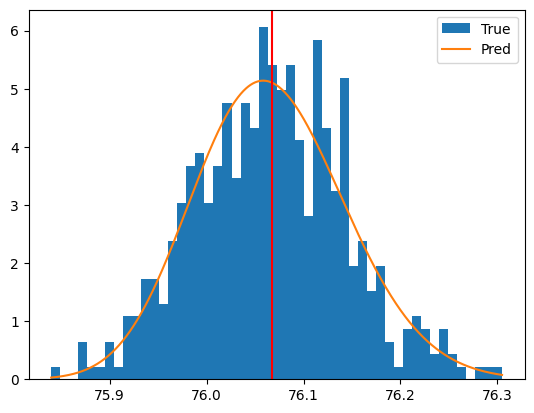

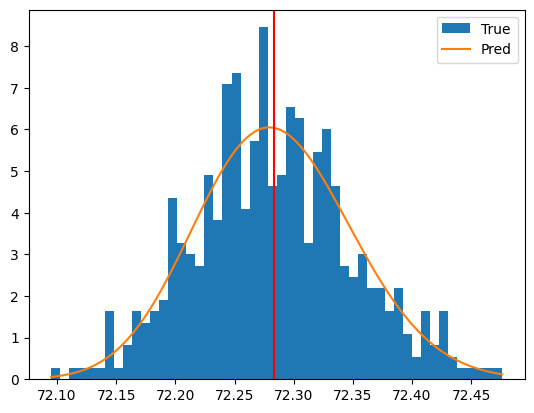

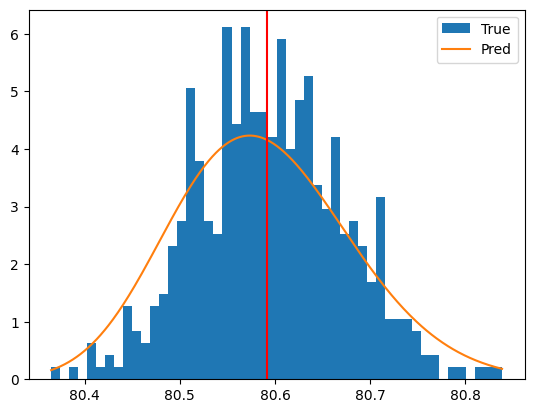

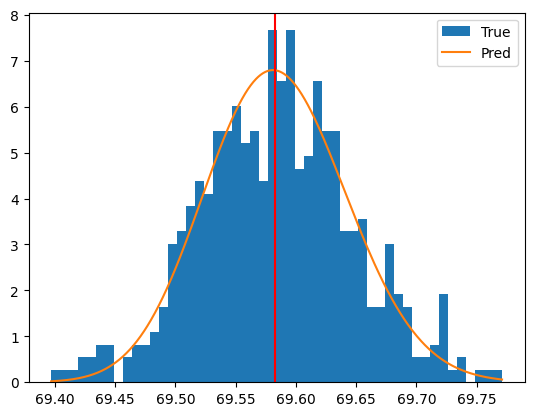

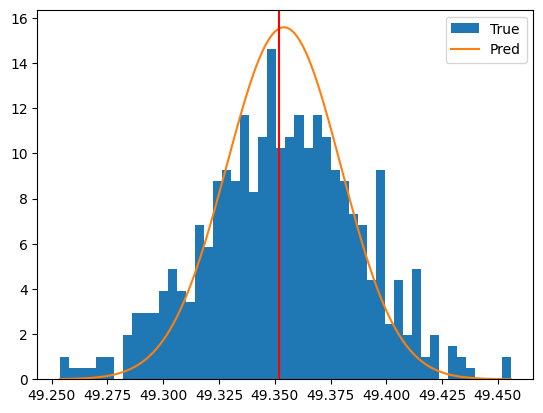

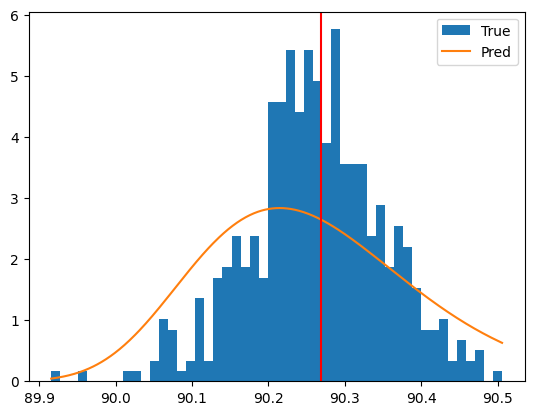

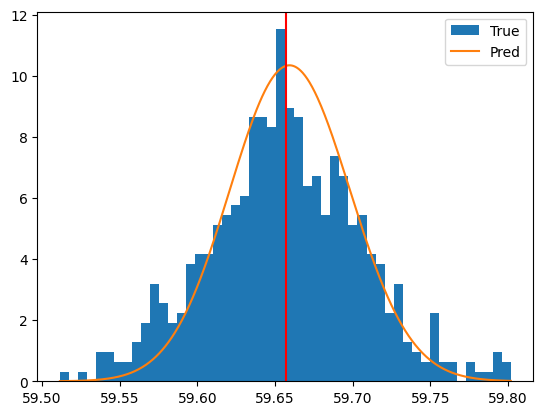

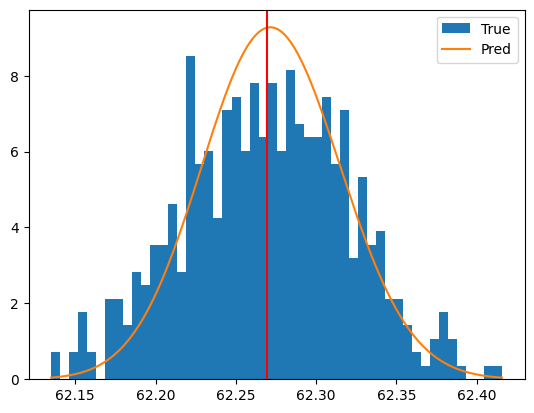

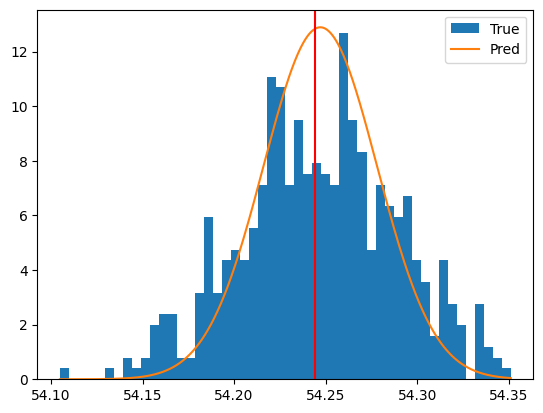

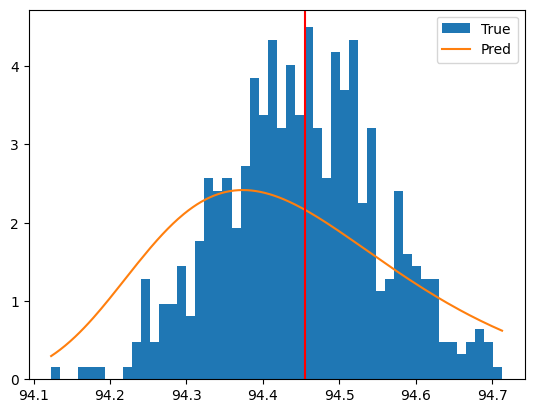

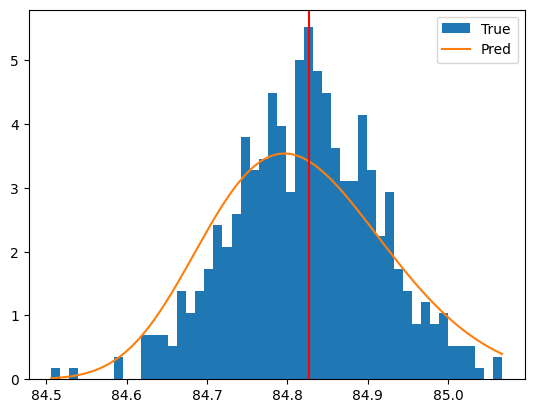

KeyboardInterrupt: 

In [30]:
for p, t in zip(posteriors, true):

    plt.hist(p, bins=50, density=True, label='True')

    xx = jnp.linspace(p.min(), p.max(), 1_000)
    pred = jnp.exp(flow.log_prob(xx[:, None], jnp.array([t])))
    plt.plot(xx, pred, label='Pred')

    plt.axvline(t, c='r')

    plt.legend()
    plt.show()

In [ ]:
import numpyro

In [ ]:
cc = jnp.array([true[0]])
potential_fn = lambda xx: -flow.log_prob(xx, cc).squeeze()
nuts = numpyro.infer.NUTS(potential_fn=potential_fn)
mcmc = numpyro.infer.MCMC(
    sampler=nuts,
    num_warmup=100,
    num_samples=10_000,
    progress_bar=True,
    jit_model_args=True,
    )
mcmc.run(jax.random.PRNGKey(1), init_params=jnp.array([1.0]))
mcmc.print_summary()

In [ ]:
pred = mcmc.get_samples().squeeze()
plt.plot(pred, lw=0.1, alpha=0.5);

In [ ]:
bins = np.linspace(
    min(posteriors[0].min(), pred.min()),
    max(posteriors[0].max(), pred.max()),
    50,
    )
plt.hist(posteriors[0], bins=bins, density=True)
plt.hist(mcmc.get_samples().squeeze(), bins=bins, density=True, histtype='step');